# Plotting using Python

IFermi can be used via the Python API. Most of the options provided in the Python API
are also accessible from the [command-line](https://ajsearle97.github.io/IFermi/cli.html).
This page gives a demonstration of the basic usage of the package.

The overall process can be summarised as:

1. Load the calculated band structure (generates a `BandStructure` object).
2. Interpolate the band structure onto a dense k-point mesh using the `Interpolater` class.
3. Extract the Fermi surface at a given energy level to create a `FermiSurface` object.
4. Plot the Fermi surface using the `FermiSurfacePlotter` class.

Below, we provide details for each of these steps.

## Loading VASP outputs

The first step is to load the VASP calculation outputs needed for the plot. This is achieved using the [pymatgen](https://pymatgen.org) package, which contains classes for parsing outputs and representing band structure calculations.

The only input required is a vasprun.xml file. Here, we use the MgB$_2$ calculation data in the `examples/MgB2/` folder. We first load the vasprun.xml using the `Vasprun` class.

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
from pymatgen.io.vasp.outputs import Vasprun

vr = Vasprun('MgB2/vasprun.xml')

Next, we extract the band structure information into a `BandStructure` object. This class contains information on the eigenvalues, k-points, and reciprocal lattice vectors.

In [3]:
bs = vr.get_band_structure()

## Interpolating onto a dense k-point mesh

There are currently two issues with our extracted band structure:

1. It only contains the irreducible portion of the Brillouin zone (since symmetry was used in the calculation) and therefore does not contain enough information to plot the Fermi surface across the full reciprocal lattice.
2. It was calculated on a relatively coarse k-point mesh and therefore will produce a rather jagged Fermi surface.

Both issues can be solved be interpolating the band structure onto a denser k-point mesh. This can be achieved using the `Interpolater` class. Internerally, this class uses the [BoltzTraP2 package](https://gitlab.com/sousaw/BoltzTraP2) to Fourier interpolate the eigenvalues on to a denser mesh that covers the full Brillouin zone.

The interpolater can be initialized using a `BandStructure` object as input.

In [4]:
from ifermi.interpolator import Interpolator

interpolator = Interpolator(bs)

The band structure can be interpolated using the `interpolate_bands()` function. The degree of interpolation is controlled by the `interpolation_factor` argument. A value of `5`, roughly indicates that the interpolated band structure will contain 5x as many k-points. Increasing the interpolation factor will result in more smooth Fermi surfaces.


<div class="alert alert-warning">
    **Warning**
    <p>As the interpolation increases, the generation of the Fermi surface and plot will take a longer time and can result in large file sizes.</p>
</div>
    

In [5]:
dense_bs, kpoint_dim = interpolator.interpolate_bands(interpolation_factor=5)

The `interpolate_bands()` function returns both the dense k-point mesh and the new k-point mesh dimensions. For example, we can check the dimensions of our new dense mesh by running:

In [6]:
print(kpoint_dim)

[25 25 19]


## Generating a Fermi surface

The next step is to extract the Fermi surface from the band structure. The `FermiSurface.from_band_structure()` function generates a `FermiSurface` object from the dense band structure we just created.

This function has a number of options that are detailed in the [FermiSurface API Reference page](https://ajsearle97.github.io/IFermi/ifermi.html#ifermi.fermi_surface.FermiSurface). The two key options are:

1. `mu` (default: `0.0`) which controls the energy offset at which the Fermi surface is calculated.
2. `wigner_seitz` (default: `False`) which controls whether the Fermi surface is calculated in the Wigner–Seitz cell or the parallelepiped reciprocal lattice cell.

MgB<sub>2</sub> is metallic, so we are mainly interested in the Fermi surface at the Fermi level. 

<div class="alert alert-info">
    **Note:** For gapped materials, <code>mu</code> must be adjusted so that it falls within the conduction band or valence band otherwise no Fermi surface will be displayed.
</div>

In [7]:
from ifermi.fermi_surface import FermiSurface

fs = FermiSurface.from_band_structure(dense_bs, kpoint_dim, mu=0.0, wigner_seitz=True)

## Plotting a Fermi surface

Finally, we can plot the Fermi surface. We do this using the `FermiSurfacePlotter`. This object supports plotting using [matplotlib](https://matplotlib.org), [plotly](https://plot.ly/) and [mayavi](https://docs.enthought.com/mayavi/mayavi/) (provided the `mayavi` package [is installed](https://docs.enthought.com/mayavi/mayavi/installation.html)).

First, the plotter is initialised from using the `FermiSurface` object.

In [8]:
from ifermi.plotter import FermiSurfacePlotter

plotter = FermiSurfacePlotter(fs)

Next, we can use the `get_plot()` function, to get a plot object. The plotting backend is controlled using the `plot_type` option. The available options are:

- `plotly` (default): We use this for all plots in this notebook.
- `matplotlib`
- `mayavi`: Requires `vtk` and `mayavi` to be installed.

The plot can be displayed directly in a jupyter notebook by calling the `show()` function.

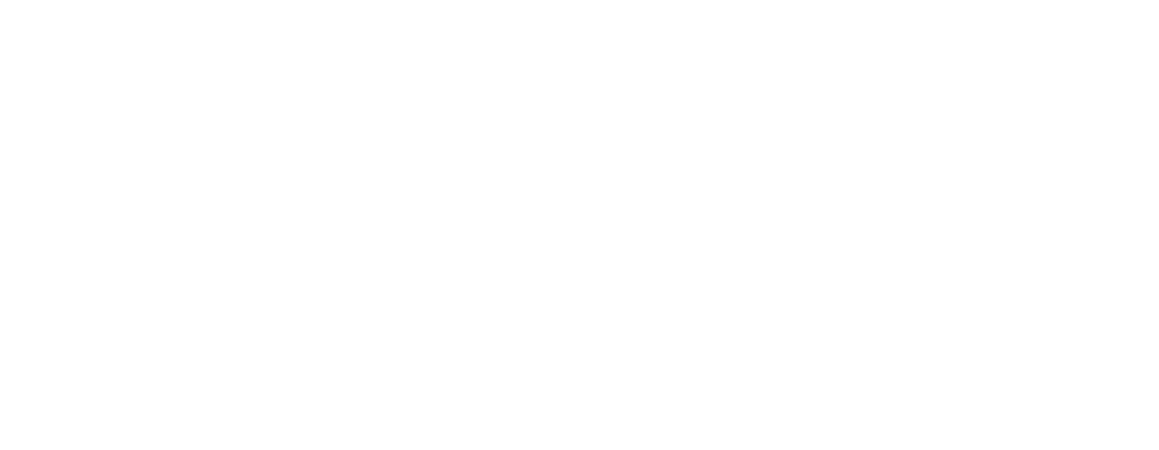

In [9]:
plot = plotter.get_plot(plot_type="plotly")
plot.show()

### Selecting spin channels

In the plot above, the spins are degenerate (the Hamiltonian does not differentiate between the up and down spins). This is why the surface looks dappled, the plotter is plotting two redundant sufaces. To stop it from doing this, we can specify that only one component of the spin should be plotted.

*Note: from now on we omit the `plot_type` argument.*

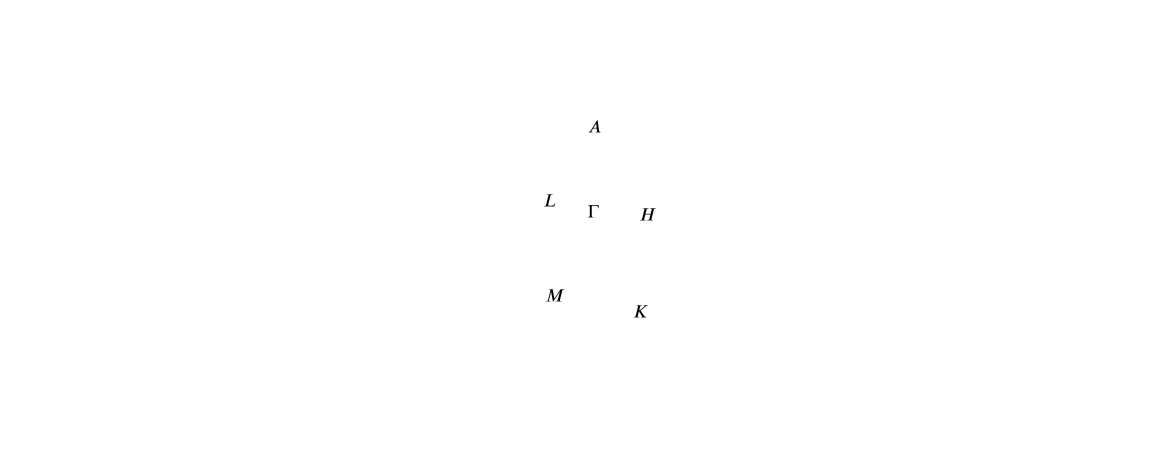

In [10]:
from pymatgen import Spin

plot = plotter.get_plot(spin=Spin.up)
plot.show()

### Customisation

You can also change the colour of the plotted surfaces. Plotly has its own module of discrete colours, which can be imported and used. You may also specify your own list of colours. Below, the predefined plotly ones are used

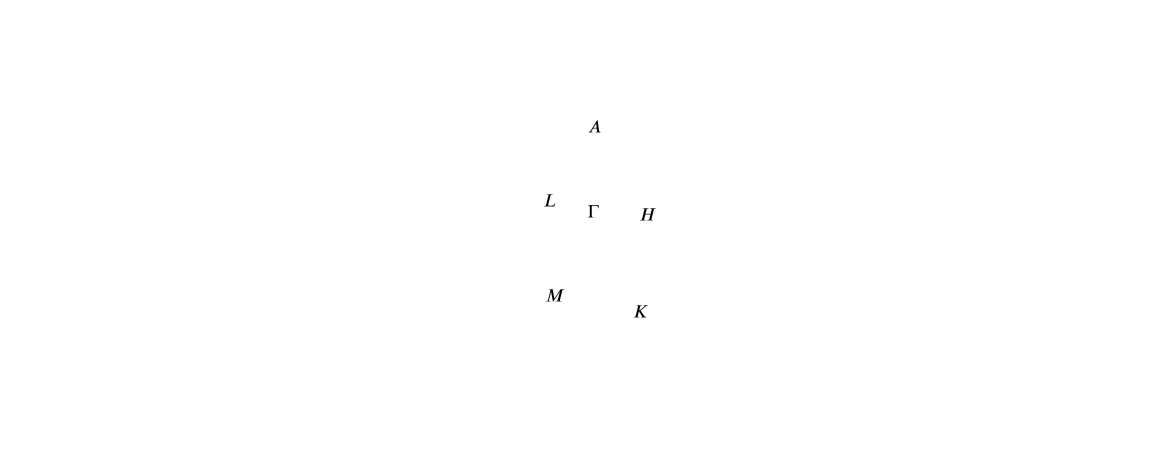

In [11]:
from plotly.express import colors

surface_colors = colors.qualitative.Dark2

plot = plotter.get_plot(spin=Spin.up, colors=surface_colors)
plot.show()

### Exporting figures

The `plot.show()` works well for viewing Fermi surfaces in a notebook but doesn't work when generating plots as part of a standalone script.

To help displaying interactive plots and saving static images you should use the `show_plot` and `save_plot` functions.


<div class="alert alert-info">
    **Note:** Once a plot has been shown, it cannot then be saved. Instead you should save the plot first then show it.
</div>

In [ ]:
from ifermi.plotter import show_plot, save_plot

save_plot(plot, "fermi-surface.png")  # saves the plot to a file
show_plot(plot)  # displays an interactive plot

## Fermi surface slices

IFermi can also generate two-dimensional slices of the Fermi surface along a specified plane. Planes are defined by their miller indices (a b c) and a distance from the plane, $d$.

`FermiSlice` objects can be generated directly from a `FermiSurface` object.

In [12]:
fermi_slice = fs.get_fermi_slice(plane_normal=(0, 0, 1), distance=0)

Fermi surface slices and be plotted using the `FermiSlicePlotter` class in a similar fashion as before.

In [13]:
from ifermi.plotter import FermiSlicePlotter

slice_plotter = FermiSlicePlotter(fermi_slice)

The plot is generated using the `get_plot()` function. Note, only matplotlib plotting is supported for slices.

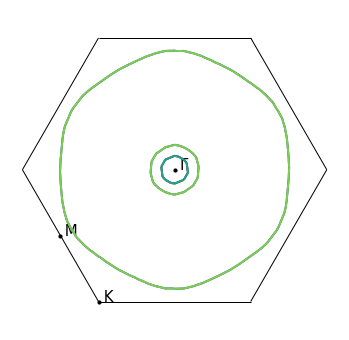

In [14]:
plot = slice_plotter.get_plot()
plot.show()